## Introdução

In [91]:
# manipulação de dados
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# data viz
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

# conexão com o banco de dados
import psycopg2
import configparser

conf = configparser.ConfigParser()
conf.read("dwh.cfg")

conn = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(*conf['CLUSTER'].values()))
cur = conn.cursor()
conn.set_session(autocommit=True)






## Quesitos Mínimos

### 1. Distância média percorrida em viagens com no máximo dois passageiros

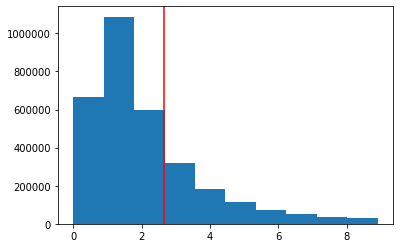

In [29]:
# Calculando a distância média
cur.execute("SELECT AVG(trip_distance) FROM trips WHERE passenger_count <= 2")
average_distance = cur.fetchone()


# coletando todos os registros relacionados a distância em corridas com até dois passageiros
cur.execute("SELECT trip_distance FROM trips WHERE passenger_count <= 2")
distribution = cur.fetchall()

# transformando o retorno do banco de dados em uma lista
distribution = [i[0] for i in distribution]

plt.hist(distribution, range=(np.min(distribution), np.nanpercentile(distribution, 95)))
plt.axvline(average_distance, color='red')
plt.show()

### 2. Quantidade total arrecadada pelas três principais empresas de taxi

In [95]:
cur.execute("""
SELECT nome, current, SUM(total_amount), COUNT(*)
FROM trips t
JOIN vendors v
ON t.vendor_id = v.vendor_id
WHERE total_amount IS NOT NULL
GROUP BY 1, 2
ORDER BY 3 DESC

""")
results = cur.fetchall()

# checando se o retorno possui o mesmo número de linhas que a tabela na cloud
assert sum([i[3] for i in results]) == 4000000

quantidade_arrecadada = [{'vendor': i[0], 'valor_total': i[2], 'numero_de_corridas': i[3]} for i in results]


In [103]:
results = pd.DataFrame(quantidade_arrecadada)
results

,numero_de_corridas,valor_total,vendor
0,1916128,19549084.280,"Creative Mobile Technologies, LLC"
1,1833052,19043434.000,VeriFone Inc
2,250816,2714901.720,"Dependable Driver Service, Inc"
3,4,45.600,Total Solutions Co


### 3. Distribuição mensal das corridas pagas em dinheiro nos últimos quatro anos

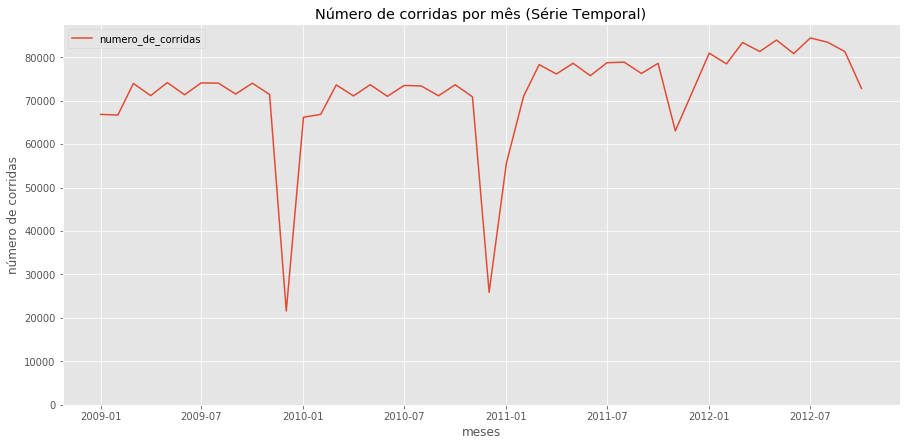

In [163]:
cur.execute("""
SELECT EXTRACT(year FROM pickup_datetime) AS year,
    EXTRACT(month FROM pickup_datetime) AS month,
      COUNT(*)
FROM trips
WHERE payment_type = 'Cash'
GROUP BY 1, 2
""")
results = cur.fetchall()


# transformando os dados obtidos em um dataframe com o index igual a data.
distribuição = [{'index': datetime.strptime(str(i[0]) + '-' + str(i[1]), '%Y-%m'), 
                 'numero_de_corridas': i[2]} for i in results]
distribuição = pd.DataFrame(distribuição).set_index('index')


# Criação de um gráfico de linhas
plt.figure(figsize=(15,7))
sns.lineplot(data=distribuição)
plt.ylabel('número de corridas')
plt.xlabel('meses')
plt.title('Número de corridas por mês (Série Temporal)')
plt.ylim(0)
plt.show()

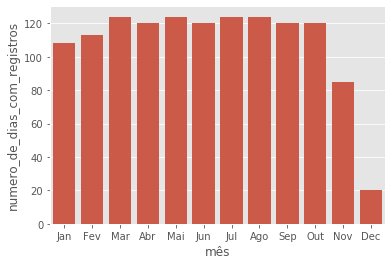

In [382]:
cur.execute("""
SELECT EXTRACT(month FROM t1.date), 
       COUNT(*), SUM(*)
FROM (SELECT pickup_datetime::date AS date, COUNT(*)
     FROM trips
     GROUP BY 1) t1
GROUP BY 1
ORDER BY 1
""")

results = cur.fetchall()
results = [{'mês': key, 'numero_de_dias_com_registros': value} for key, value in results]
results = pd.DataFrame(results)


month_mappers = {1: 'Jan', 2:'Fev', 3:'Mar', 4:'Abr', 5:'Mai', 6: 'Jun',
                 7: 'Jul', 8: 'Ago', 9: 'Sep', 10: 'Out', 11: 'Nov', 12: 'Dec'}

results['mês'] = results['mês'].map(month_mappers)

sns.barplot(data=results, x='mês', y='numero_de_dias_com_registros', color=sns.color_palette()[0])
plt.show()

### 4. Quantidade diária de gorgeta nos últimos três meses de 2012

In [271]:
cur.execute("""
SELECT pickup_datetime::date, SUM(tip_amount)
FROM trips
WHERE EXTRACT(month FROM pickup_datetime) >= 10
AND EXTRACT(year FROM pickup_datetime) = 2012
GROUP BY 1
""")
results = cur.fetchall()

results = [{'date': value[0], 'quantidade_diária': value[1]} for value in results]
results = pd.DataFrame(results).sort_values(ascending=True, by='date').set_index('date')

In [272]:
results = [{'date': value[0], 'quantidade_diária': value[1]} for value in results]
results = pd.DataFrame(results).sort_values(ascending=True, by='date').set_index('date')

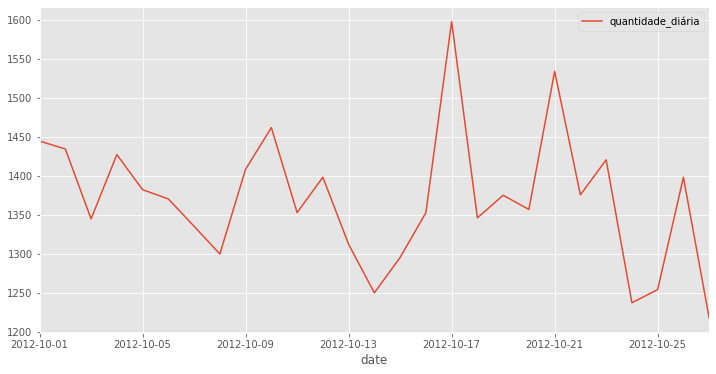

In [276]:
results.plot(kind='line', figsize=(12, 6))

In [306]:
cur.execute("""
SELECT pickup_datetime::date, SUM(tip_amount)
FROM trips
WHERE EXTRACT(month FROM pickup_datetime) >= 10
GROUP BY 1
""")
results = cur.fetchall()
results = pd.DataFrame(results)
results = results.rename({0: 'date', 1: 'total_de_gorgetas'}, axis=1)
results['date'] = pd.to_datetime(results['date'])
results = results.set_index('date').resample('y').count()
results['year'] = results.index.year

In [322]:
results = cur.fetchall()
results = [{'index': datetime.strptime(str(i[0]) + '-' + str(i[1]), '%Y%m'), 
          'numero_de_corridas': i[2]} for i in results]

In [326]:
results = pd.DataFrame(results)

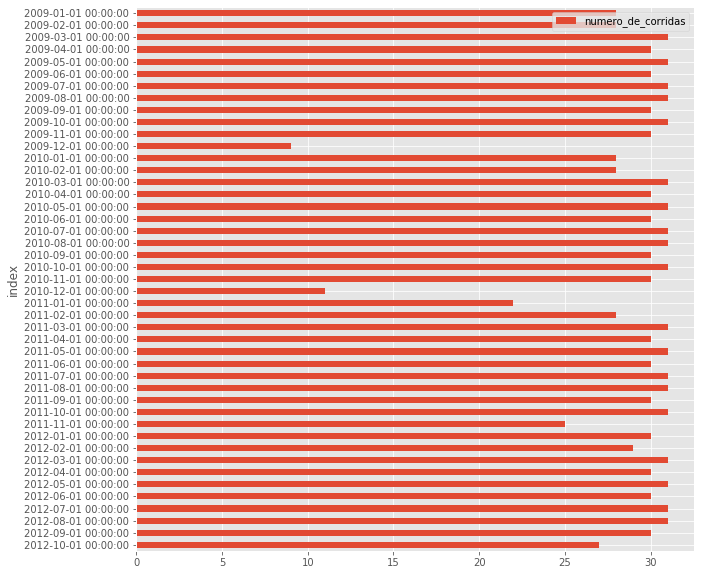

In [334]:
results.sort_values(ascending=False, by='index').set_index('index').plot(kind='barh', figsize=(10,10))

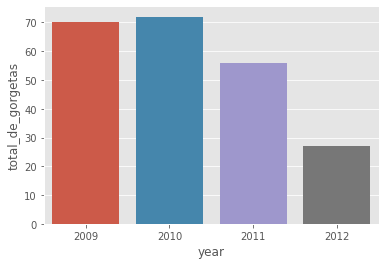

In [311]:
sns.barplot(data=results, x='year', y='total_de_gorgetas')

## Quesitos bônus

### Tempo médio de corridas nos sábados e domingos

In [ ]:
cur.execute("""
SELECT EXTRACT(dow from t1.inicio_datetime), AVG(t1.tempo_total)
FROM (SELECT (EXTRACT(epoch FROM fim_datetime) - EXTRACT(epoch FROM inicio_datetime)) / 60 AS tempo_total,
        inicio_datetime
    FROM trips) t1
WHERE EXTRACT(dow from t1.inicio_datetime) IN (0.0, 6.0)
GROUP BY 1
""")